In [1]:
!pip install xgboost



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\Aparna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
!pip install xgboost psycopg2-binary


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: C:\Users\Aparna\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


importing all the necessary libs

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
file_path = "ecopackai_unique_materials_dataset.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (35, 11)


,material_name,tensile_strength_mpa,max_load_kg,unit_cost_usd,biodegradability_score,co2_kg_per_unit,recyclability_percent,moisture_resistance_score,food_safe,shelf_life_months,sustainability_index
0,PLA Bioplastic,43.36,22.4,5.47,7,1.08,90,9,0,44,55.00
1,Bamboo Fiber Board,67.63,42.8,1.26,5,0.89,64,8,0,25,48.16
2,Molded Pulp Tray,10.01,50.9,1.27,3,3.39,62,9,0,12,24.99
3,Sugarcane Bagasse Box,34.19,6.0,4.94,8,1.05,49,7,1,19,43.31
4,Mushroom Mycelium Foam,21.74,46.3,2.69,3,0.89,54,6,0,42,44.46


In [5]:
# Features (X)
X = df[
    ["tensile_strength_mpa",
     "max_load_kg",
     "recyclability_percent",
     "biodegradability_score"]
]

# Targets (y)
y_cost = df["unit_cost_usd"]
y_co2  = df["co2_kg_per_unit"]

In [6]:
X_train, X_test, y_cost_train, y_cost_test = train_test_split(
    X, y_cost, test_size=0.2, random_state=42
)

_, _, y_co2_train, y_co2_test = train_test_split(
    X, y_co2, test_size=0.2, random_state=42
)

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#### RANDOM FOREST -> COST PRED

In [8]:
rf_cost = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_cost.fit(X_train_scaled, y_cost_train)

RandomForestRegressor(random_state=42)

In [9]:
y_cost_pred = rf_cost.predict(X_test_scaled)

In [10]:
mae = mean_absolute_error(y_cost_test, y_cost_pred)
rmse = np.sqrt(mean_squared_error(y_cost_test, y_cost_pred))
r2 = r2_score(y_cost_test, y_cost_pred)

print("COST PREDICTION METRICS")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


COST PREDICTION METRICS
MAE: 1.2377857142857143
RMSE: 1.4838959527444735
R2: -0.41337580273727137


##### XGBoost Regression -> CO₂ Prediction

In [11]:
xgb_co2 = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

xgb_co2.fit(X_train_scaled, y_co2_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
y_co2_pred = xgb_co2.predict(X_test_scaled)


In [13]:
mae = mean_absolute_error(y_co2_test, y_co2_pred)
rmse = np.sqrt(mean_squared_error(y_co2_test, y_co2_pred))
r2 = r2_score(y_co2_test, y_co2_pred)

print("CO2 PREDICTION METRICS")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


CO2 PREDICTION METRICS
MAE: 0.9915179841858999
RMSE: 1.2119973334036989
R2: -0.6815389692909715


##### Ranking based on pred cost and CO2 pred

In [14]:
# Predict on full dataset
X_all_scaled = scaler.transform(X)

df["predicted_cost"] = rf_cost.predict(X_all_scaled)
df["predicted_co2"]  = xgb_co2.predict(X_all_scaled)

df[["material_name", "predicted_cost", "predicted_co2"]].head()


,material_name,predicted_cost,predicted_co2
0,PLA Bioplastic,5.1357,1.080389
1,Bamboo Fiber Board,2.3588,0.890565
2,Molded Pulp Tray,1.8151,3.378637
3,Sugarcane Bagasse Box,4.2744,1.052174
4,Mushroom Mycelium Foam,2.8227,0.890441


In [15]:
from sklearn.preprocessing import MinMaxScaler

rank_scaler = MinMaxScaler()

df[["cost_norm", "co2_norm"]] = rank_scaler.fit_transform(
    df[["predicted_cost", "predicted_co2"]]
)

# Lower is better → invert score
df["eco_score"] = 1 - (0.5 * df["cost_norm"] + 0.5 * df["co2_norm"])

# Rank
df["rank"] = df["eco_score"].rank(ascending=False)

df.sort_values("rank")


,material_name,tensile_strength_mpa,max_load_kg,unit_cost_usd,biodegradability_score,co2_kg_per_unit,recyclability_percent,moisture_resistance_score,food_safe,shelf_life_months,sustainability_index,predicted_cost,predicted_co2,cost_norm,co2_norm,eco_score,rank
5,Recycled PET Sheet,17.39,59.4,1.41,4,0.41,68,3,1,29,53.21,1.9397,0.417254,0.120998,0.061055,0.908973,1.0
28,Natural Latex Foam,23.59,27.8,0.52,8,1.03,30,7,0,42,37.79,1.4763,1.032391,0.000000,0.256092,0.871954,2.0
30,Recycled Aluminum Thin Sheet,17.87,34.5,2.30,8,0.62,49,6,0,33,47.08,2.5312,0.617680,0.275445,0.124602,0.799976,3.0
1,Bamboo Fiber Board,67.63,42.8,1.26,5,0.89,64,8,0,25,48.16,2.3588,0.890565,0.230430,0.211124,0.779223,4.0
4,Mushroom Mycelium Foam,21.74,46.3,2.69,3,0.89,54,6,0,42,44.46,2.8227,0.890441,0.351559,0.211085,0.718678,5.0
25,Mycelium Insulated Box,81.57,10.6,1.80,8,0.54,92,6,0,8,60.68,3.2550,0.546352,0.464437,0.101987,0.716788,6.0
18,Bagasse Clamshell,21.23,19.6,4.15,8,0.62,58,8,1,42,49.78,3.3488,0.625755,0.488929,0.127163,0.691954,7.0
31,Glassine Paper Wrap,43.69,41.5,3.40,3,0.65,39,5,1,14,42.06,3.3400,0.662092,0.486631,0.138684,0.687342,8.0
33,Compostable Fiber Tray,52.65,57.0,2.46,6,1.36,40,8,0,8,37.20,2.7581,1.357993,0.334691,0.359328,0.652990,9.0
13,Banana Fiber Paper,80.25,20.8,2.42,8,1.55,94,4,1,35,52.44,3.6907,0.653628,0.578203,0.136000,0.642899,10.0


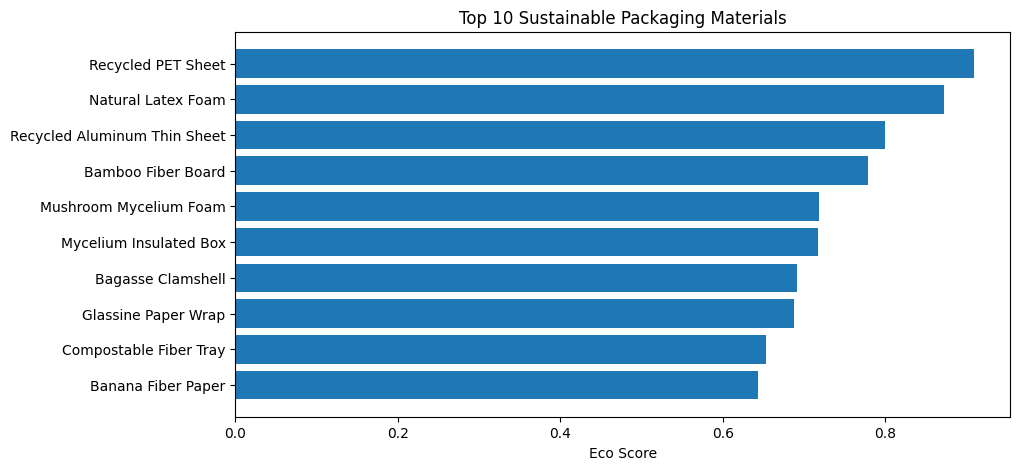

In [16]:
import matplotlib.pyplot as plt

top10 = df.sort_values("rank").head(10)

plt.figure(figsize=(10,5))
plt.barh(top10["material_name"], top10["eco_score"])
plt.xlabel("Eco Score")
plt.title("Top 10 Sustainable Packaging Materials")
plt.gca().invert_yaxis()
plt.show()


In [17]:
y_cost_class = pd.qcut(y_cost_test, 3, labels=["Low", "Medium", "High"])
y_cost_pred_class = pd.qcut(y_cost_pred, 3, labels=["Low", "Medium", "High"])


In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_cost_class, y_cost_pred_class))


              precision    recall  f1-score   support

        High       0.50      0.33      0.40         3
         Low       0.33      0.50      0.40         2
      Medium       0.50      0.50      0.50         2

    accuracy                           0.43         7
   macro avg       0.44      0.44      0.43         7
weighted avg       0.45      0.43      0.43         7



##### Using other important metrics as well for ranking 

In [19]:
rank_features = [
    "tensile_strength_mpa",
    "max_load_kg",
    "recyclability_percent",
    "biodegradability_score",
    "predicted_cost",
    "predicted_co2"
]

from sklearn.preprocessing import MinMaxScaler
rank_scaler = MinMaxScaler()

df_norm = pd.DataFrame(
    rank_scaler.fit_transform(df[rank_features]),
    columns=rank_features
)


In [20]:
df_norm["predicted_cost"] = 1 - df_norm["predicted_cost"]
df_norm["predicted_co2"]  = 1 - df_norm["predicted_co2"]


In [21]:
df["eco_score"] = (
    0.20 * df_norm["recyclability_percent"] +
    0.20 * df_norm["biodegradability_score"] +
    0.15 * df_norm["tensile_strength_mpa"] +
    0.15 * df_norm["max_load_kg"] +
    0.15 * df_norm["predicted_cost"] +
    0.15 * df_norm["predicted_co2"]
)

df["rank"] = df["eco_score"].rank(ascending=False)


In [22]:
df.sort_values("rank")[[
    "material_name",
    "eco_score",
    "predicted_cost",
    "predicted_co2",
    "recyclability_percent",
    "biodegradability_score"
]]


,material_name,eco_score,predicted_cost,predicted_co2,recyclability_percent,biodegradability_score
13,Banana Fiber Paper,0.737145,3.6907,0.653628,94,8
25,Mycelium Insulated Box,0.726967,3.2550,0.546352,92,8
24,Cellulose Film,0.648990,2.7584,1.587474,80,5
1,Bamboo Fiber Board,0.621649,2.3588,0.890565,64,5
32,Wood Pulp Molded Box,0.595202,4.3008,3.279632,81,8
27,Agro Fiber Panel,0.590334,3.2558,1.330055,84,7
5,Recycled PET Sheet,0.589068,1.9397,0.417254,68,4
23,Bamboo Molded Tray,0.567641,4.3142,0.224690,78,4
26,Recycled Carton Board,0.566732,3.1187,1.223318,74,8
30,Recycled Aluminum Thin Sheet,0.561313,2.5312,0.617680,49,8


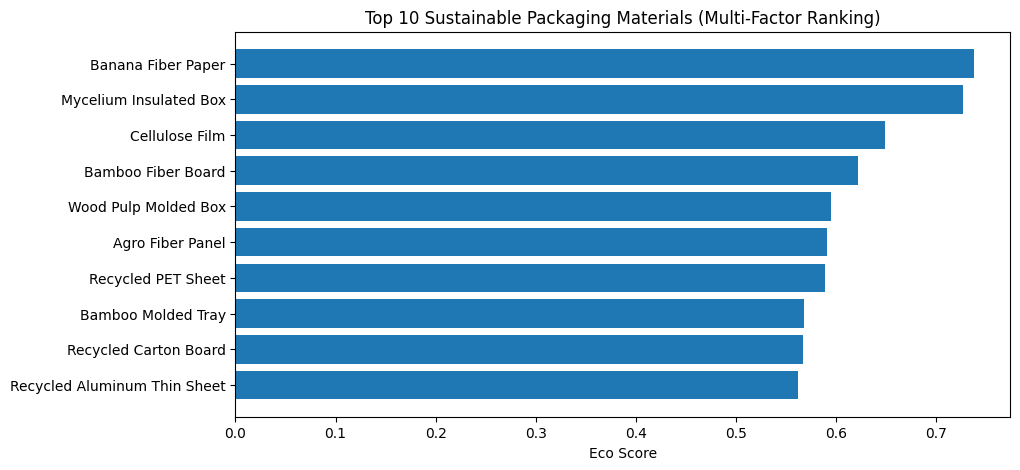

In [23]:
top10 = df.sort_values("rank").head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.barh(top10["material_name"], top10["eco_score"])
plt.xlabel("Eco Score")
plt.title("Top 10 Sustainable Packaging Materials (Multi-Factor Ranking)")
plt.gca().invert_yaxis()
plt.show()


In [24]:
import joblib

joblib.dump(rf_cost, "cost_model.pkl")
joblib.dump(xgb_co2, "co2_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']